In [1]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_visa.py'>

# Analysis 0: Calibration

In [2]:
data_save=joblib.load("../Keysight/data_waveform/waveform_calib_CH1.joblib")
time_series = data_save["metadata"]["time_series"]*1e9

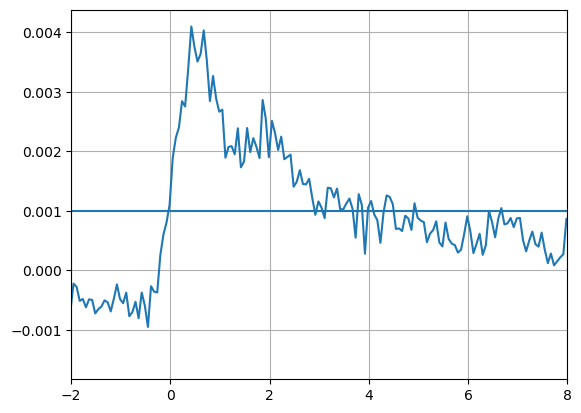

In [3]:
# Have a look at one pulse, and choose a trigger threshold
trigger_threshold_edge = 0.001

plot(time_series, data_save[1][0])
axhline(trigger_threshold_edge)

xlim(-2,8)
grid()

In [4]:
process_result = {}


for ch in [1]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"amplitudef1_fit_{ch}"]=[]
    process_result[f"amplitudef2_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"tfall2_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    

for i in tqdm(range(len(data_save[1]))):
# for i in tqdm(range(1000)):
    for ch in [1]:
        x=time_series
        y=data_save[ch][i]
        dt = (time_series[1]-time_series[0])
        
        

        # Edge trigger:
        trigger_time_edge = (np.argmax( y>trigger_threshold_edge)-len(x)//2)*dt
        amplitude = np.max(y)
    
    
        # # CFD trigger
        # leading_edges = hp.constant_fraction_discriminator(y, 0, trigger_threshold_edge, trigger_threshold_cfd, gauss_filter=8)
        # if len(leading_edges)>0:
        #     trigger_time_cfd = (leading_edges[0][1]-2048)*(time_series[1]-time_series[0])
        # else:
        #     trigger_time_cfd = -999
           
        # Fit
        try:
            popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, fit_range=[-20,30], p0=[1,3,30,np.max(y),np.max(y)/3,x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=False, color="C0", linestyle="--", label="CH1, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ") 
            chi2=np.linalg.norm(info["fvec"])
        except KeyboardInterrupt:
            print("  KeyboardInterrupt. You pressed ctrl c...")
            break                
        except Exception as e: # Any other exception
            # print("  Exception:", str(e)) # Displays the exception without raising it
            popt = [-999, -999, -999, -999,-999,-999,-999]
            chi2=-999
            
        trigger_time_fit = popt[5]
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        # process_result[f"trigger_time_cfd_{ch}"].append(trigger_time_cfd)
        process_result[f"trigger_time_fit_{ch}"].append(trigger_time_fit)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"amplitude_fit_{ch}"].append(popt[6])
        process_result[f"amplitudef1_fit_{ch}"].append(popt[3])
        process_result[f"amplitudef2_fit_{ch}"].append(popt[4])
        process_result[f"trise_fit_{ch}"].append(popt[0])
        process_result[f"tfall_fit_{ch}"].append(popt[1])
        process_result[f"tfall2_fit_{ch}"].append(popt[2])
        process_result[f"fit_chi2_{ch}"].append(chi2)        
        
for key in process_result:
    process_result[key]=np.array(process_result[key])        

  0%|          | 0/5000 [00:00<?, ?it/s]/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  0%|          | 8/5000 [00:00<02:29, 33.42it/s]/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:56: RuntimeWarning: overflow encountered in exp
  pulse = (A1     *     (np.exp(-times[mask] / tau_f1))
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:57: RuntimeWarning: overflow encountered in exp
  +A2     *     (np.exp(-times[mask] / tau_f2))
  0%|          | 13/5000 [00:00<02:10, 

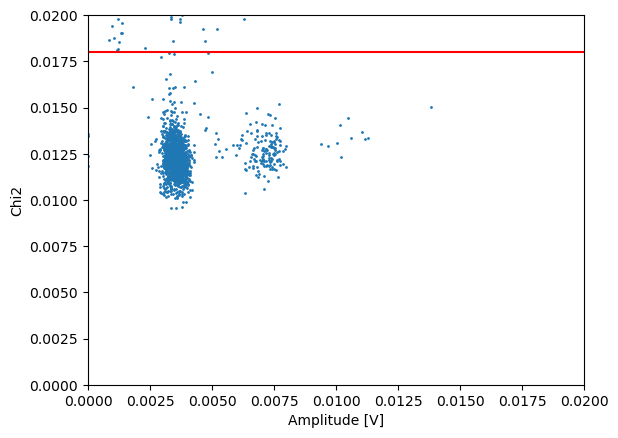

In [11]:
# Chi2 cut
scatter(process_result[f"amplitude_fit_1"],process_result[f"fit_chi2_1"] , s=1);
xlim(0,0.02)
ylim(0,0.02)
xlabel("Amplitude [V]")
ylabel("Chi2")

chi2_cut_threshold = 0.018
axhline(chi2_cut_threshold,color="r")

10%-90% rise time 0.3557768131960119 ns


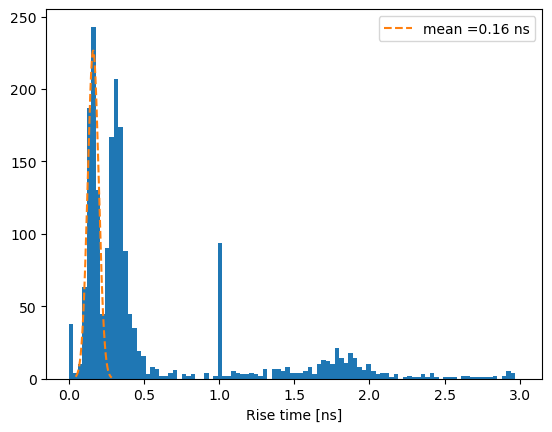

In [7]:
#  Rise time
h=hist(process_result[f"trise_fit_{ch}"],bins=100,range=(0,3));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="mean ={popt[1]:.2f} ns", color="C1", linestyle="--", fit_range=(0.02,0.3));

xlabel("Rise time [ns]")
legend()

print("10%-90% rise time", 2.2*popt[1], "ns")

Amplitude of the first eh: 0.003522039617610929


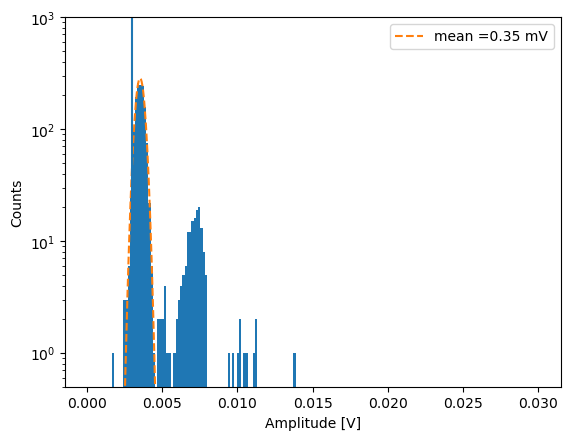

In [8]:
h=hist(process_result[f"amplitude_fit_1"][process_result[f"fit_chi2_1"]<chi2_cut_threshold], bins=np.linspace(0,0.03,200));

popt, pcov, info, f = hp.fit_hist("gauss", h, label="mean ={popt[1]*100:.2f} mV", color="C1", linestyle="--", fit_range=(0.0005,0.01));


legend()
xlabel("Amplitude [V]")
ylabel("Counts")
yscale("log")
ylim(0.5,1e3)
legend()

amp2eh = popt[1] # 2.5 mV/eh
print("Amplitude of the first eh:",popt[1])
axvline(0.003)

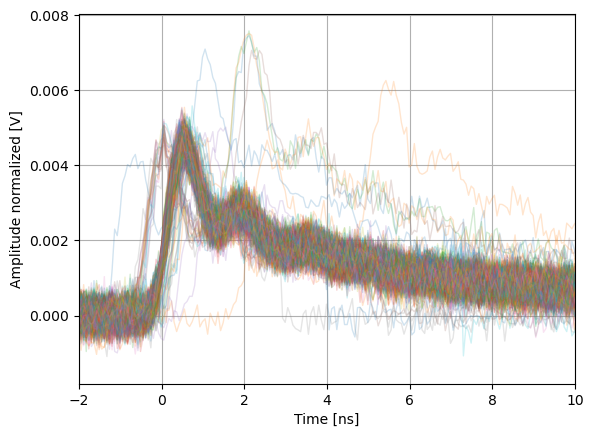

In [9]:
# for i in range(len(data_save[1])):
trace_original = []
trace_aligned = []
trace_amps = []
time_series = data_save["metadata"]["time_series"]*1e9
for i in range(len(data_save[1])):
# for i in range(100):
    trace = data_save[1][i]
    trace-= np.mean(trace[:1024-200])
    # if (max(trace)>0.025) or  (max(trace)<0.02) or (min(trace)<-0.005):
    #     continue     
    # leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
    # trigger_offset = leading_edges[0][1]-2048
    # trigger_offset = np.argmax( y>trigger_threshold_edge)-2048
    
    if process_result["fit_chi2_1"][i] > chi2_cut_threshold:
        continue
    # if abs(process_result["amplitude_fit_1"][i]-popt[1])>0.003:
    if process_result["amplitude_fit_1"][i]<0.003 or process_result["amplitude_fit_1"][i]>0.005:
        continue
    
    amp = process_result["amplitude_fit_1"][i]
    trace_amps.append(amp)
    # trace/=amp

    trigger_offset = int(process_result["trigger_time_fit_1"][i]/dt)
    
    trace_original.append(trace)
    trace = np.roll(trace, -trigger_offset)
    trace_aligned.append(trace)
    
    if i <2000:
        plot(time_series, trace,alpha=0.2, linewidth=1)

xlim(-2,10)
xlabel("Time [ns]")
ylabel("Amplitude normalized [V]")
grid()

[ 4.11237689e-01  4.11909324e-01  6.88445526e+00  6.52735659e+00
  5.41668215e-03 -1.00456395e-01  3.97130954e-03]


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:58: RuntimeWarning: overflow encountered in exp
  -(A1+A2) * (np.exp(-times[mask] / tau_r))


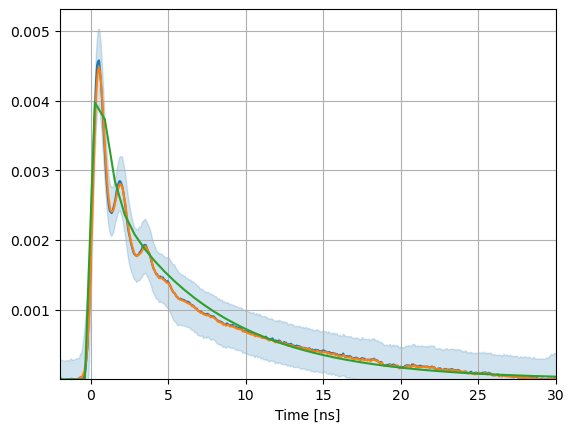

In [13]:
trace_original_avg = np.mean(trace_original, axis=0)#*np.mean(trace_amps)
trace_aligned_avg = np.mean(trace_aligned, axis=0)#*np.mean(trace_amps)
trace_aligned_std = np.std(trace_aligned, axis=0)#*np.mean(trace_amps)


scintillator_pulse_15eh_save = [time_series, trace_aligned_avg, trace_aligned_std]
np.save("scintillator_pulse_15eh", scintillator_pulse_15eh_save)


plot(time_series, trace_original_avg)
plot(time_series, trace_aligned_avg)
fill_between(time_series, trace_aligned_avg-trace_aligned_std, trace_aligned_avg+trace_aligned_std, color="C0", alpha=0.2)


x=time_series
y=trace_aligned_avg
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[0.5,3,30,np.max(y),np.max(y),x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=True)

# yscale("log")
xlim(-2,30)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")
print(popt)

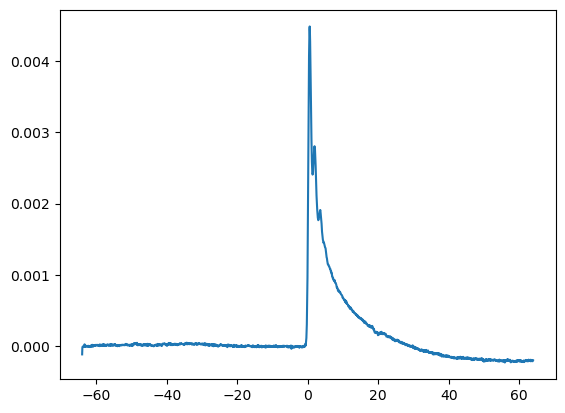

In [14]:
plot(time_series,trace_aligned_avg)

In [16]:
pulse_save = {"time_series_ns":time_series,
              "averaged_pulse_1pe_volt":trace_aligned_avg}
# joblib.dump(pulse_save,"../Keysight/data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")

['../Keysight/data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib']